# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of four classes: Normal, Viral, Pneumonio, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

# Prepare data

In [2]:
class_names = ['normal', 'viral', 'covid', 'lung']
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']
root_dir = '/Users/selmee/coursera/COVID-19_Radiography_Dataset'

if not os.path.isdir(os.path.join(root_dir, 'test')):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
        for i, d in enumerate(source_dirs):
            os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
    
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = class_names
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, idx):
        class_name = random.choice(self.class_names)
        idx = idx % len(self.images[class_name])
        image_name = self.images[class_name][idx]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        
        return self.transform(image), self.class_names.index(class_name)

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [6]:
train_dirs = {'normal': os.path.join(root_dir, 'normal'),
                'lung': os.path.join(root_dir, 'lung'),
                'covid': os.path.join(root_dir, 'covid'),
                'viral': os.path.join(root_dir, 'viral')}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples
Found 5982 lung examples


In [7]:
test_dirs = {'normal': os.path.join(root_dir, 'test', 'normal'),
                'lung': os.path.join(root_dir, 'test', 'lung'),
                'covid': os.path.join(root_dir, 'test', 'covid'),
                'viral': os.path.join(root_dir, 'test', 'viral')}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples
Found 30 lung examples


In [8]:
batch_size = 6

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size, shuffle=False)

In [9]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)

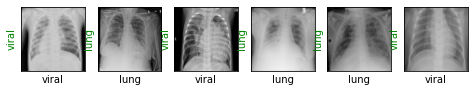

In [10]:
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

# Modeling

In [11]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [12]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [13]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=4)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [15]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(test_loader))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

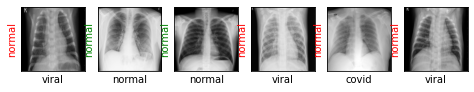

In [16]:
show_preds()

In [17]:
def train(epochs):
    
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(test_loader):
                    outputs = resnet18(images)
                    loss = criterion(outputs, labels)
                    val_loss = loss.item()
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                
                resnet18.train()
                
                if acc > 0.95:
                    return 
                
            train_loss /= (train_step + 1)
            print(f'Training loss: {train_loss:.4f}')

In [18]:
train(epochs=1)

Starting epoch 1/1
Evaluating at step 0
Val loss: 0.0644, Acc: 0.3750
Training loss: 1.5077
Training loss: 1.5085
Training loss: 1.0690
Training loss: 0.6690
Training loss: 0.3286
Training loss: 0.3379
Training loss: 0.2309
Training loss: 0.2454
Training loss: 0.1796
Training loss: 0.1018
Training loss: 0.0951
Training loss: 0.0982
Training loss: 0.0926
Training loss: 0.0791
Training loss: 0.0772
Training loss: 0.0618
Training loss: 0.0771
Training loss: 0.0637
Training loss: 0.0504
Training loss: 0.0438
Evaluating at step 20
Val loss: 0.0643, Acc: 0.4167
Training loss: 0.0493
Training loss: 0.0439
Training loss: 0.0494
Training loss: 0.0390
Training loss: 0.0456
Training loss: 0.0678
Training loss: 0.0450
Training loss: 0.0450
Training loss: 0.0520
Training loss: 0.0384
Training loss: 0.0147
Training loss: 0.0241
Training loss: 0.0273
Training loss: 0.0184
Training loss: 0.0273
Training loss: 0.0133
Training loss: 0.0319
Training loss: 0.0186
Training loss: 0.0524
Training loss: 0.021

Training loss: 0.0004
Training loss: 0.0012
Training loss: 0.0007
Training loss: 0.0027
Training loss: 0.0004
Training loss: 0.0011
Training loss: 0.0008
Training loss: 0.0008
Training loss: 0.0006
Training loss: 0.0006
Training loss: 0.0011
Evaluating at step 340
Val loss: 0.0331, Acc: 0.8583
Training loss: 0.0003
Training loss: 0.0028
Training loss: 0.0015
Training loss: 0.0011
Training loss: 0.0002
Training loss: 0.0006
Training loss: 0.0024
Training loss: 0.0014
Training loss: 0.0018
Training loss: 0.0010
Training loss: 0.0002
Training loss: 0.0007
Training loss: 0.0007
Training loss: 0.0004
Training loss: 0.0010
Training loss: 0.0007
Training loss: 0.0003
Training loss: 0.0007
Training loss: 0.0008
Training loss: 0.0019
Evaluating at step 360
Val loss: 0.0079, Acc: 0.8917
Training loss: 0.0005
Training loss: 0.0006
Training loss: 0.0013
Training loss: 0.0026
Training loss: 0.0012
Training loss: 0.0007
Training loss: 0.0003
Training loss: 0.0011
Training loss: 0.0008
Training loss:

Training loss: 0.0002
Training loss: 0.0005
Training loss: 0.0008
Training loss: 0.0015
Training loss: 0.0002
Training loss: 0.0005
Training loss: 0.0008
Training loss: 0.0009
Training loss: 0.0006
Training loss: 0.0009
Training loss: 0.0006
Training loss: 0.0015
Training loss: 0.0004
Training loss: 0.0012
Training loss: 0.0006
Training loss: 0.0006
Training loss: 0.0010
Training loss: 0.0001
Training loss: 0.0003
Evaluating at step 680
Val loss: 0.0310, Acc: 0.9167
Training loss: 0.0002
Training loss: 0.0001
Training loss: 0.0005
Training loss: 0.0003
Training loss: 0.0004
Training loss: 0.0007
Training loss: 0.0003
Training loss: 0.0007
Training loss: 0.0003
Training loss: 0.0005
Training loss: 0.0006
Training loss: 0.0005
Training loss: 0.0006
Training loss: 0.0001
Training loss: 0.0001
Training loss: 0.0009
Training loss: 0.0005
Training loss: 0.0005
Training loss: 0.0003
Training loss: 0.0008
Evaluating at step 700
Val loss: 0.0060, Acc: 0.9417
Training loss: 0.0004
Training loss:

Training loss: 0.0002
Training loss: 0.0003
Training loss: 0.0006
Training loss: 0.0003
Training loss: 0.0001
Evaluating at step 1000
Val loss: 0.0192, Acc: 0.9083
Training loss: 0.0001
Training loss: 0.0003
Training loss: 0.0004
Training loss: 0.0002
Training loss: 0.0010
Training loss: 0.0003
Training loss: 0.0003
Training loss: 0.0001
Training loss: 0.0002
Training loss: 0.0000
Training loss: 0.0004
Training loss: 0.0000
Training loss: 0.0003
Training loss: 0.0002
Training loss: 0.0001
Training loss: 0.0000
Training loss: 0.0003
Training loss: 0.0001
Training loss: 0.0003
Training loss: 0.0001
Evaluating at step 1020
Val loss: 0.0053, Acc: 0.9500
Training loss: 0.0009
Training loss: 0.0002
Training loss: 0.0010
Training loss: 0.0005
Training loss: 0.0002
Training loss: 0.0006
Training loss: 0.0001
Training loss: 0.0003
Training loss: 0.0003
Training loss: 0.0003
Training loss: 0.0000
Training loss: 0.0003
Training loss: 0.0001
Training loss: 0.0001
Training loss: 0.0008
Training los

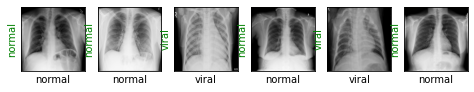

In [20]:
show_preds()